IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



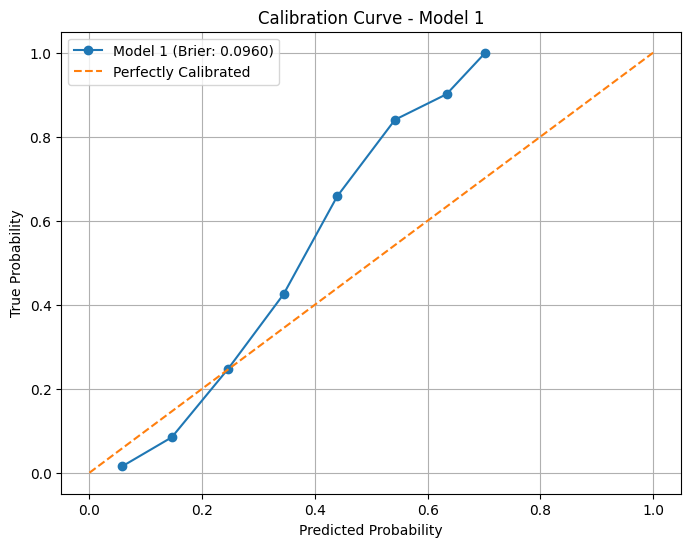

Model 1 Brier Score: 0.0960


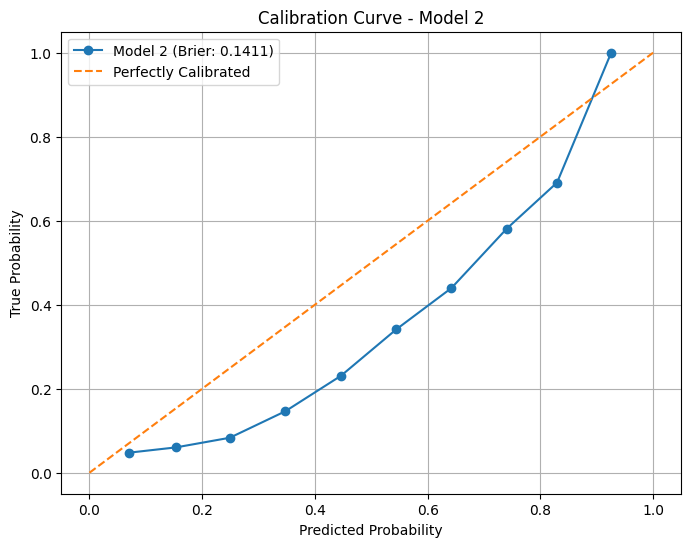

Model 2 Brier Score: 0.1411
Fairness Metrics by Sensitive Feature for Model 1:
                        selection_rate  accuracy
persoon_geslacht_vrouw                          
0                             0.015062  0.860188
1                             0.013210  0.859868
Equalized Odds Difference for Model 1: 0.007253338077306992

Fairness Metrics by Sensitive Feature for Model 2:
                        selection_rate  accuracy
persoon_geslacht_vrouw                          
0                             0.103077  0.839386
1                             0.165965  0.806788
Equalized Odds Difference for Model 2: 0.10094088811140434

Structure of results: [array([0, 0, 0, ..., 0, 0, 0], shape=(60000,)), [{0: 0.7415685653686523, 1: 0.25843146443367004}, {0: 0.7034105062484741, 1: 0.2965894639492035}, {0: 0.9382529854774475, 1: 0.06174704059958458}, {0: 0.9509379267692566, 1: 0.049062058329582214}, {0: 0.550789475440979, 1: 0.4492104947566986}, {0: 0.902459442615509, 1: 0.09754056483507

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, brier_score_loss
from sklearn.calibration import calibration_curve
from fairlearn.metrics import MetricFrame, selection_rate, equalized_odds_difference
import onnxruntime as rt
import matplotlib.pyplot as plt

data = pd.read_csv('../data/300k_dataset.csv')
# data = data[:6]
y = data['checked']
X = data.drop(['checked', 'Ja', 'Nee'], axis=1)
X = X.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_path_1 = "../Group 9/model_1.onnx"
model_path_2 = "../Group 9/model_2.onnx"
session_1 = rt.InferenceSession(model_path_1)
session_2 = rt.InferenceSession(model_path_2)

def extract_probabilities(session, X_test):
    results = session.run(None, {'X': X_test.values.astype(np.float32)})

    print("Structure of results:", results)

    try:
        if isinstance(results[1], list):
            probabilities = [result[1] for result in results[1]]
        else:
            probabilities = [results[1]]
    except Exception as e:
        print(f"Error during extraction: {e}")
        probabilities = []

    return np.array(probabilities)

y_prob_1 = extract_probabilities(session_1, X_test)
y_prob_2 = extract_probabilities(session_2, X_test)

y_pred_1 = np.rint(y_prob_1).astype(int)
y_pred_2 = np.rint(y_prob_2).astype(int)

def print_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n")

print_metrics(y_test, y_pred_1, "Model 1")
print_metrics(y_test, y_pred_2, "Model 2")

def calibration_test(y_true, y_prob, model_name):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
    brier_score = brier_score_loss(y_true, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label=f'{model_name} (Brier: {brier_score:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.title(f'Calibration Curve - {model_name}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"{model_name} Brier Score: {brier_score:.4f}")

calibration_test(y_test, y_prob_1, "Model 1")
calibration_test(y_test, y_prob_2, "Model 2")

X_test['persoon_geslacht_vrouw'] = data.loc[X_test.index, 'persoon_geslacht_vrouw']
X_test['persoon_leeftijd_bij_onderzoek'] = data.loc[X_test.index, 'persoon_leeftijd_bij_onderzoek']

sensitive_feature = 'persoon_geslacht_vrouw'

def fairness_test(y_true, y_pred, sensitive_feature, model_name):
    metric_frame = MetricFrame(
        metrics={'selection_rate': selection_rate, 'accuracy': accuracy_score},
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=X_test[sensitive_feature]
    )
    print(f"Fairness Metrics by Sensitive Feature for {model_name}:")
    print(metric_frame.by_group)

    equalized_odds = equalized_odds_difference(
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=X_test[sensitive_feature]
    )
    print(f"Equalized Odds Difference for {model_name}: {equalized_odds}\n")

fairness_test(y_test, y_pred_1, sensitive_feature, "Model 1")
fairness_test(y_test, y_pred_2, sensitive_feature, "Model 2")

def noise_resilience_test(session, X_test, y_test, model_name):
    X_test_noisy = X_test.copy()
    noise = np.random.normal(0, 0.1, X_test_noisy.shape)
    X_test_noisy += noise

    y_prob_noisy = extract_probabilities(session, X_test_noisy)
    y_pred_noisy = np.rint(y_prob_noisy).astype(int)

    accuracy_noisy = accuracy_score(y_test, y_pred_noisy)
    print(f"{model_name} Accuracy with Noise: {accuracy_noisy}")

noise_resilience_test(session_1, X_test, y_test, "Model 1")
noise_resilience_test(session_2, X_test, y_test, "Model 2")


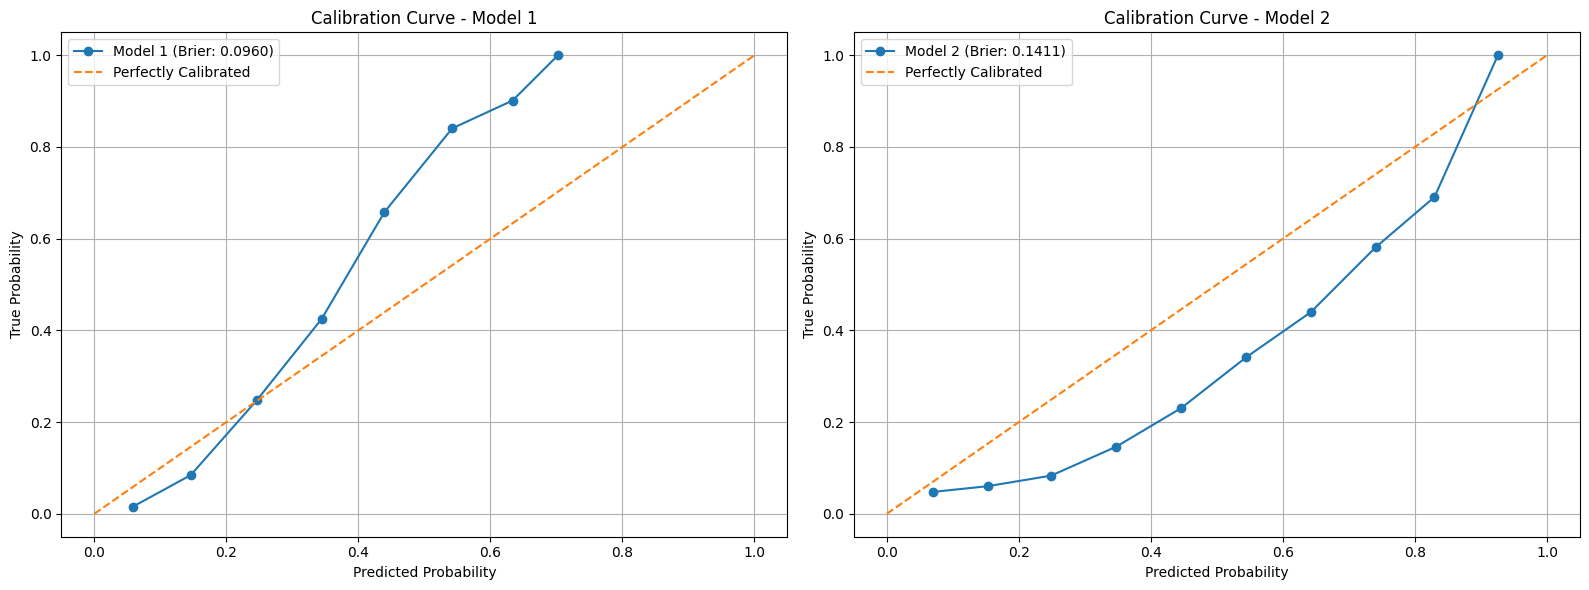

Model 1 Brier Score: 0.0960
Model 2 Brier Score: 0.1411


In [14]:
def calibration_test(y_true, y_prob_1, y_prob_2, model_name_1, model_name_2):
    prob_true_1, prob_pred_1 = calibration_curve(y_true, y_prob_1, n_bins=10, strategy='uniform')
    brier_score_1 = brier_score_loss(y_true, y_prob_1)

    prob_true_2, prob_pred_2 = calibration_curve(y_true, y_prob_2, n_bins=10, strategy='uniform')
    brier_score_2 = brier_score_loss(y_true, y_prob_2)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].plot(prob_pred_1, prob_true_1, marker='o', label=f'{model_name_1} (Brier: {brier_score_1:.4f})')
    axes[0].plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    axes[0].set_title(f'Calibration Curve - {model_name_1}')
    axes[0].set_xlabel('Predicted Probability')
    axes[0].set_ylabel('True Probability')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(prob_pred_2, prob_true_2, marker='o', label=f'{model_name_2} (Brier: {brier_score_2:.4f})')
    axes[1].plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    axes[1].set_title(f'Calibration Curve - {model_name_2}')
    axes[1].set_xlabel('Predicted Probability')
    axes[1].set_ylabel('True Probability')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    print(f"{model_name_1} Brier Score: {brier_score_1:.4f}")
    print(f"{model_name_2} Brier Score: {brier_score_2:.4f}")

calibration_test(y_test, y_prob_1, y_prob_2, "Model 1", "Model 2")
